# Starting point
I have done some data analysis and feature engineering in my notebook `Initial Data Exploration`. I have also plugged these features into mu own implementations of a **Naive Bayes Classifier** and a **Maximum Entropy Classifier**. My submission scored **0.80382**.

I want to improve on these fronts:
* Explore and improve my features
* Investigate crossvalidation as a means of tuning my model parameters
* Test other predictive models

This time around I have drawn some inspiration from some Kaggle kernels, and I have also put some more thought into my features. 

Lets start of with some data exploration again!

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy import stats

%matplotlib inline

# Data Exploration
I will take the time to reiterate some of my insights from the first notebook that I think are relevant, but also hope to draw some new ones. Iterating forward!

## The Data Set
Lets divide the data into categories, and explore what variable have missing values.

In [2]:
training_data = pd.read_csv('titanic_train.csv')

In [3]:
training_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


**Categorical Variables**
* Sex
* Embarked
* Name
* Ticket
* Cabin

**Ordinal Variables**
* Pclass
* SibSp
* Parch

**Discrete Variables**
* Age

**Continous Variables**
* Fare

I choose to classify Parch and SibSp as ordinal as they are discrete variables with a very limited span.

In [4]:
training_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

This time around I will handle missing values with more finesse. Atleast for Age.

## Target variable: Survived
Lets look at survived on it's own for a bit.

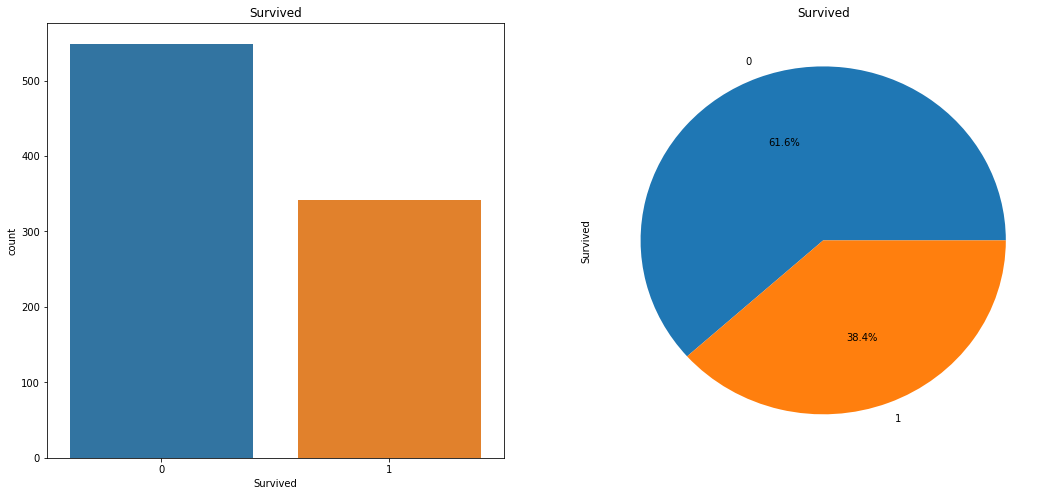

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))
#training_data['Survived'].value_counts().plot('bar', ax = ax[0])
sns.countplot('Survived', data = training_data, ax = ax[0])
training_data['Survived'].value_counts().plot('pie', ax = ax[1], autopct = "%1.1f%%")

ax[0].set_title('Survived')
ax[1].set_title('Survived')


38.4 % Survival rate! Lets look into our other variables.

## The independents
Last time I favoured these variables:
* `Sex` - Women has much higher survival rates than men
* `Pclass` - Passengers of higher class had higher survival rates than those of lower (1 is highest class)
* `Age` - Children had good survival rates. I classifed passangers as a child if younger than 18
* `Name` - I extracted the passengers title such as Mr, Mrs and Miss
* `Ticket` - I identified companies traveling together through their ticket number and tried to infer a passangers fate from the fate of their companions
* `Embarked` - I did not do much analysis
* `Parch` and `SibSP` - I did not do much analysis

Lets evaluate them again, but also get into other variables I might have overlooked!

### Sex and Title


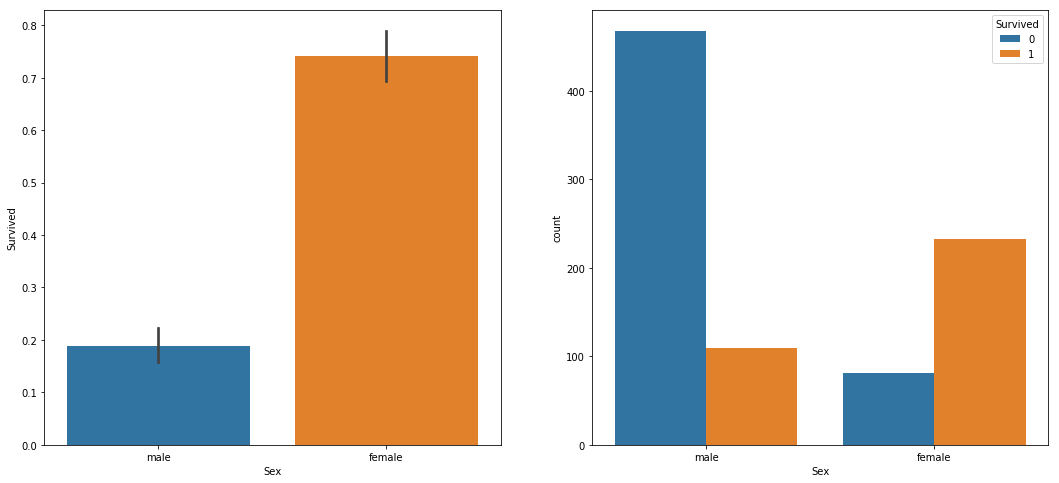

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.barplot(x='Sex', y='Survived', data = training_data, ax = ax[0])
sns.countplot('Sex', hue='Survived', data = training_data, ax = ax[1])


It is clear that females were far more likely to survive. But last time I also introduced the `Title` variable. Having both `Sex` and `Title` might be redundant.

In [7]:
training_data['Title'] = training_data['Name'].str.extract(r'.*\,\s(.*?)\.', expand=False)

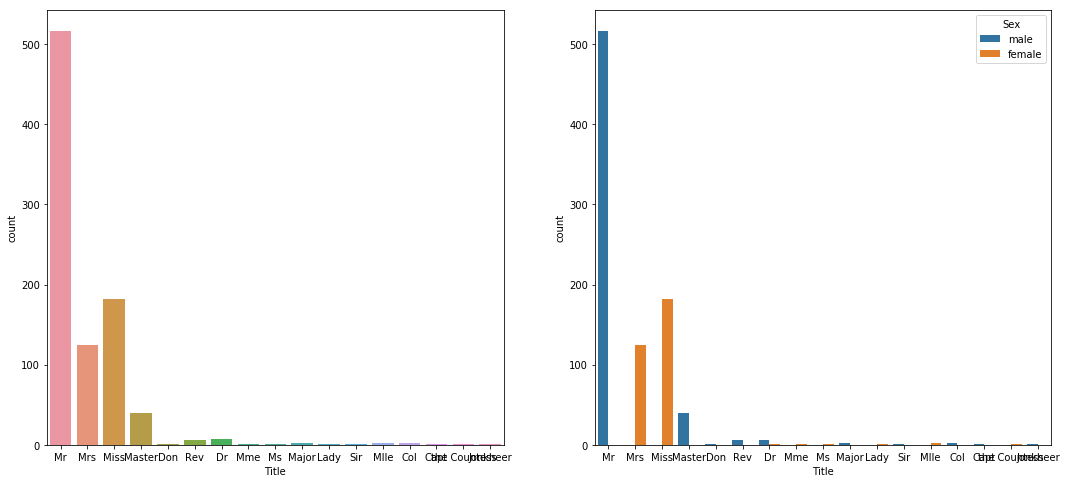

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))
sns.countplot('Title', data=training_data, ax = ax[0])
sns.countplot('Title', hue='Sex', data = training_data, ax = ax[1])

Only the title Dr is shared by both men and women.

In [9]:
training_data[training_data['Title'] == 'Dr']['Sex'].value_counts()

male      6
female    1
Name: Sex, dtype: int64

Keeping the variable `Sex` seems redundant when it can be infered from `Title` in all but one case. Also `Title` carries more information:

* **Mr**: Male
* **Mrs**: Married female
* **Miss**: Unmarried female
* **Master**: Young boy
* etc.

It might be usefull to convert less comon titles to one of the four most common titles. I think this can be done safely using the passengers `Sex` and `Age`. Lets create rules for this.

The first rule is easy:
If `Sex` is male, then we choose either Mr or Master.
If `Sex` is female, then we choose either Mrs or Miss.

Lets turn to `Age` to finalize the desiscion.

Starting with Mr and Master. I want to determine at what point males are no longer boys, and recieve the title Mr.

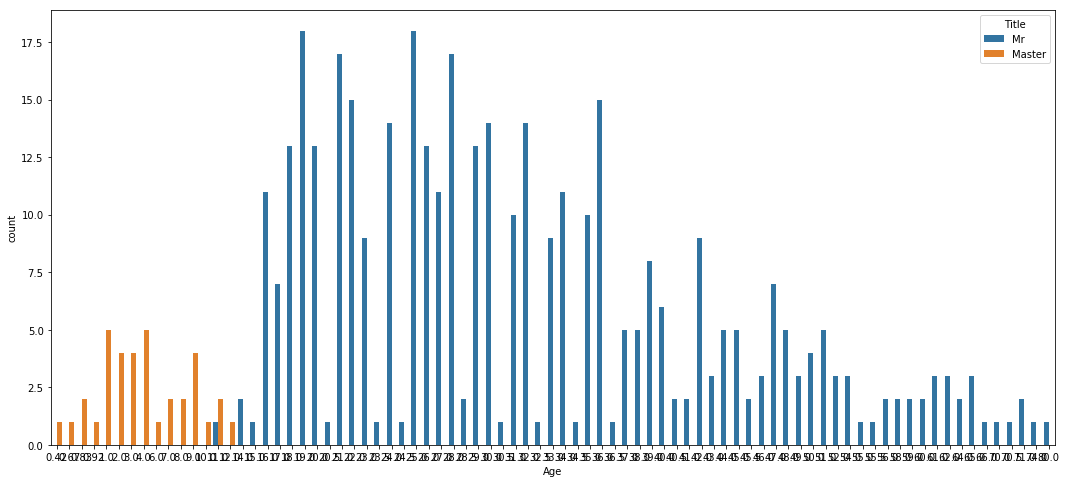

In [10]:
fig, ax = plt.subplots(figsize=(18,8))
sns.countplot('Age', hue = 'Title', data=training_data[training_data['Title'].apply(lambda x: x in ['Mr', 'Master'])], ax = ax)
#sns.countplot(training_data[training_data['Title'] == 'Mr']['Age'].dropna(), ax = ax[1])

We se one passenger with the title Mr at the age of 11, other than the youngest is 14. The oldest Master is 12, and there are two at the age of 11. I think it is fair to classify any male with `Age` <= 12 as Master. Question is, does splitting the men up with two titles have any effect if we also keep the age variable around? Maybe we should call all men Man?

But lets move on to Mrs and Miss. Here the title does carry meaning, married or not married. I have a feeling categorizing null values will be more hairy here.

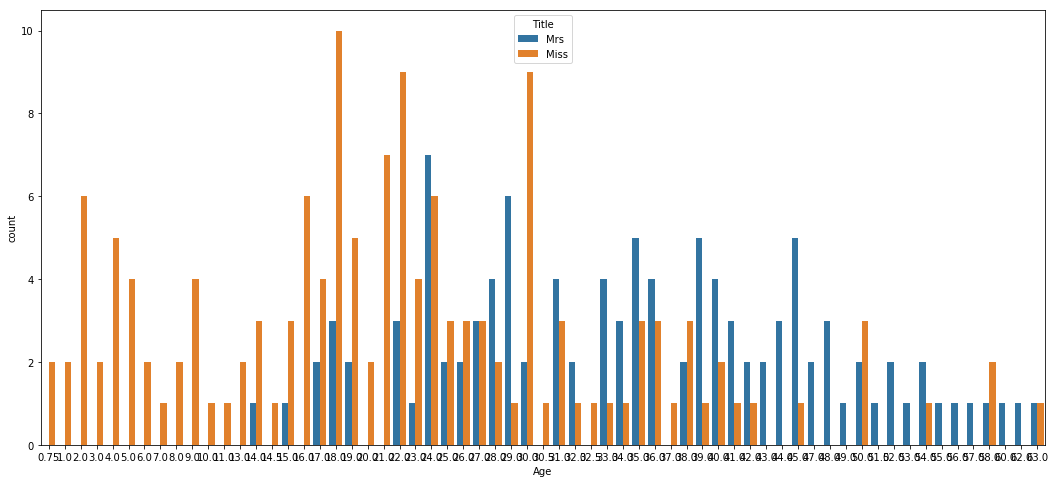

In [11]:
fig, ax = plt.subplots(figsize=(18,8))
sns.countplot('Age', hue = 'Title', data=training_data[training_data['Title'].apply(lambda x: x in ['Mrs', 'Miss'])], ax = ax)
#sns.countplot(training_data[training_data['Title'] == 'Mr']['Age'].dropna(), ax = ax[1])

In [12]:
training_data[training_data['Title'] == 'Mrs']['Age'].describe()

count    108.000000
mean      35.898148
std       11.433628
min       14.000000
25%       27.750000
50%       35.000000
75%       44.000000
max       63.000000
Name: Age, dtype: float64

In [13]:
training_data[training_data['Title'] == 'Miss']['Age'].describe()

count    146.000000
mean      21.773973
std       12.990292
min        0.750000
25%       14.125000
50%       21.000000
75%       30.000000
max       63.000000
Name: Age, dtype: float64

There are women with the title Miss at all ages, though less common when older. The youngest married woman is 14. It is clear that the likelihood of having the `Title` miss is higher at younger ages, but where should I draw the line?

The two classes Miss and Mrs are clearly not linearly separable, but I think a classfication with k-nearest neighbours or similar tactic would just overfit to my sample. My assumption is that for the whole population there exists some age that separates the two classes like so: "If above or at age X it is more likely that a femlae has the title Mrs". I will seek the optimal such constant for my data set. (Should this be updated using the test set as well?)

I will only consider whole numbers as ages, even though babies below 1 year old also use fractions. No Mrs is below 14 anyway.

In [14]:
mrs_miss_data = training_data[training_data['Title'].apply(lambda x: x in ['Mrs', 'Miss'])]

In [15]:
miss_classified_miss = [mrs_miss_data[(mrs_miss_data['Title'] == 'Miss') & (mrs_miss_data['Age'] >= age)].shape[0] for age in range(int(mrs_miss_data['Age'].max()+1))]
miss_classified_mrs = [mrs_miss_data[(mrs_miss_data['Title'] == 'Mrs') & (mrs_miss_data['Age'] < age)].shape[0] for age in range(int(mrs_miss_data['Age'].max()+1))]
     

In [16]:
miss_classifications = pd.DataFrame.from_dict(data={'Miss': miss_classified_miss, 'Mrs': miss_classified_mrs})

In [17]:
miss_classifications['Total'] = miss_classifications['Miss'] + miss_classifications['Mrs']  

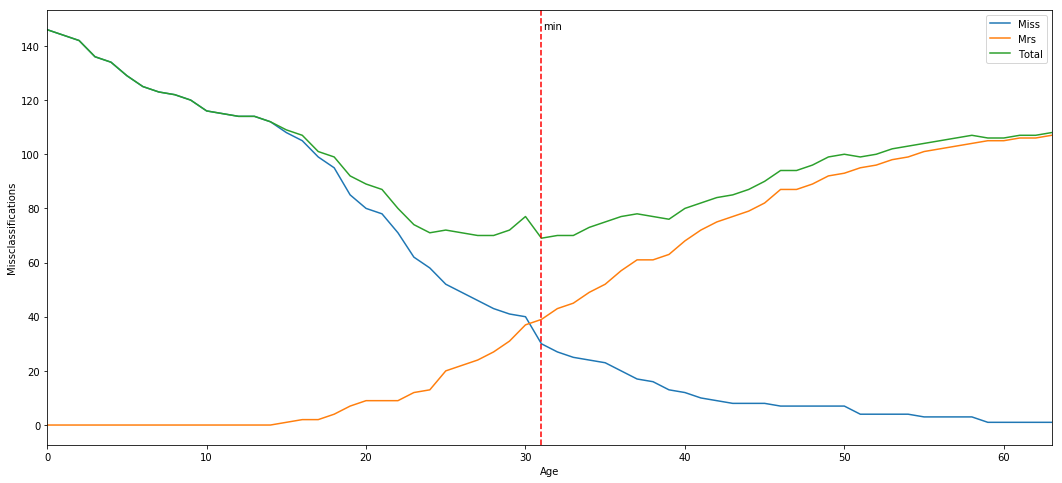

In [18]:
fig, ax = plt.subplots(figsize=(18,8))
miss_classifications.plot(ax = ax)
plt.xlabel('Age')
plt.ylabel('Missclassifications')
plt.axvline(miss_classifications['Total'].idxmin(), color='r', ls = '--')
plt.text(miss_classifications['Total'].idxmin() + 0.1, miss_classifications['Total'].max(), 'min')

In [19]:
print("Classify all women with unknown titles as Mrs if they are {} years old or older.".format(miss_classifications['Total'].idxmin()))

Classify all women with unknown titles as Mrs if they are 31 years old or older.


Obviously my method still overfits to the training data, but much less so than a fancier method would. But maybe there is some other way to find a constant boundary that overfits less?

Some conclusions:
I will diregard the `Sex` attribute, and instead use `Title`. For women I will only allow Mrs and Miss, all other women will be given one of these titles based on age. For men I have decicded to only use the title Man, as I believe dividing men into Mr and Master only carries information about their age, which is redundant when we have the `Age` variable. Women with unknown `Title` will be given the title Miss if below  the age of 31 and Mrs otherwise.

In [20]:
def set_title(row):
    if row['Sex'] == 'male':
        return "Man"
    elif row['Title'] in ['Miss', 'Mrs']:
        return row['Title']
    elif row['Age'] >= 31:
        return "Mrs"
    else:
        return "Miss"

training_data['Title'] = training_data.apply(set_title, axis=1)

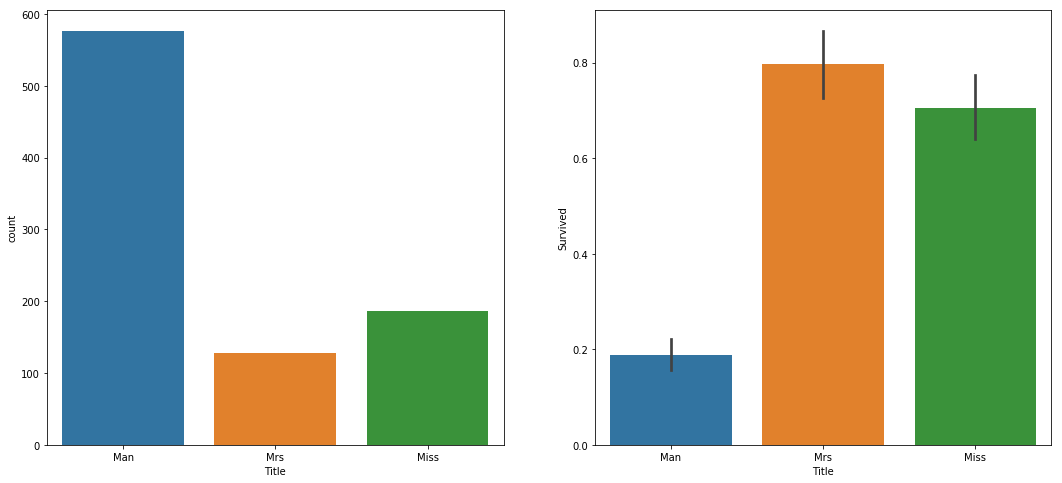

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))
sns.countplot('Title', data=training_data, ax = ax[0])
sns.barplot('Title', 'Survived', data = training_data, ax = ax[1])

### Age

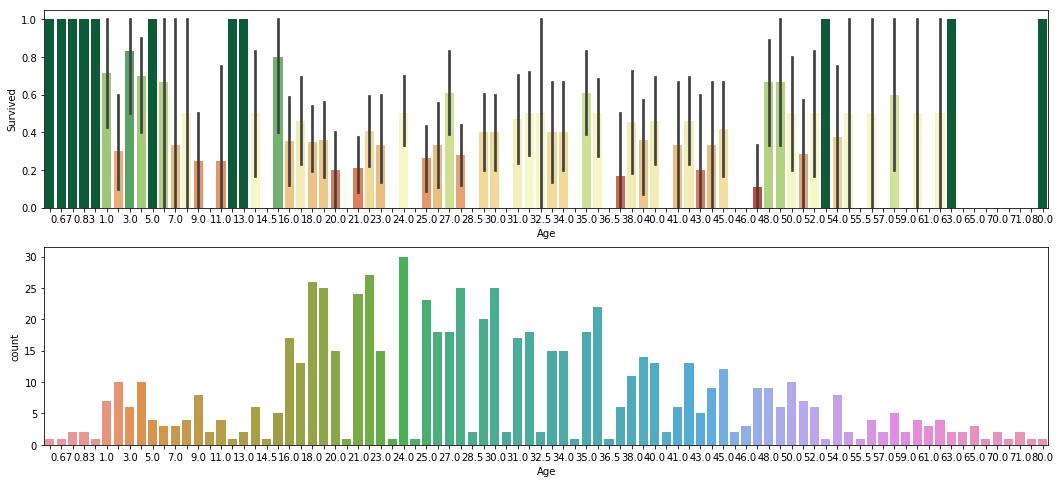

In [22]:
fig, ax = plt.subplots(2, 1,figsize=(18,8))
sns.barplot(x='Age', y='Survived', data=training_data, ax = ax[0], palette = plt.cm.RdYlGn(training_data.groupby('Age').agg({'Survived' : 'mean'})['Survived']))
sns.countplot(x='Age', data=training_data, ax= ax[1])
for label in ax[0].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
for label in ax[1].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


#xlabels = [item.get_text() for item in ax[0].get_xticklabels()]

#plt.xticks([i for i in np.arange(0, training_data['Age'].max(), 2)]);

Children are more likely to survive than others. Also it seems other age groups might have similar survival rates. Lets create some different age groups. I will do a lot of wild handwaving when setting these boundaries.

I want one group for toddlers, as survival rate is very high for young children. Lets say anyone ages 3 or below is a toddler. 4-12 is a kid, 13-17 is a teen, 18-27 is a young adult, 28-39 is an adult, 40-55 is middle aged and 56+ is a pensioner.

In [23]:
training_data['Age Group'] = training_data['Age'].apply(lambda x:
                                                           'Toddler' if x <= 3 else
                                                           'Kid' if x <= 12 else
                                                           'Teen' if x <= 17 else
                                                           'Young Adult' if x <= 27 else
                                                           'Adult' if x <= 39 else
                                                           'Middle Aged' if x <= 55 else
                                                           'Pensioner' if 0 <= x <=100 else
                                                           None)

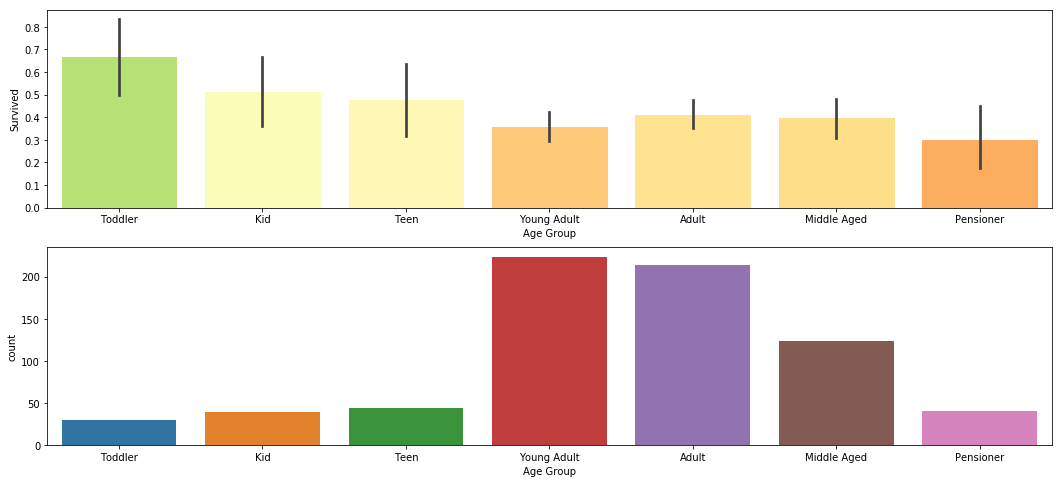

In [24]:
order = ['Toddler', 'Kid', 'Teen', 'Young Adult', 'Adult', 'Middle Aged', 'Pensioner']
fig, ax = plt.subplots(2, 1, figsize=(18,8))
sns.barplot(x='Age Group', y='Survived', data=training_data, ax = ax[0], order = order)
# I'm kind of undoing the whole purpose of seaborn doing these manual modifications, but for now I don't know of a better way.
for p in ax[0].patches:
    p.set_color(plt.cm.RdYlGn(p.get_height()))
    
sns.countplot(x='Age Group', data = training_data, order = order)


The age groups have a very skewed distribution. Younger ages where there are less passengers have the most finegrained bins. I think this is still warranted as I feel a small diference in age is a bigger deal for children than for adaults. 

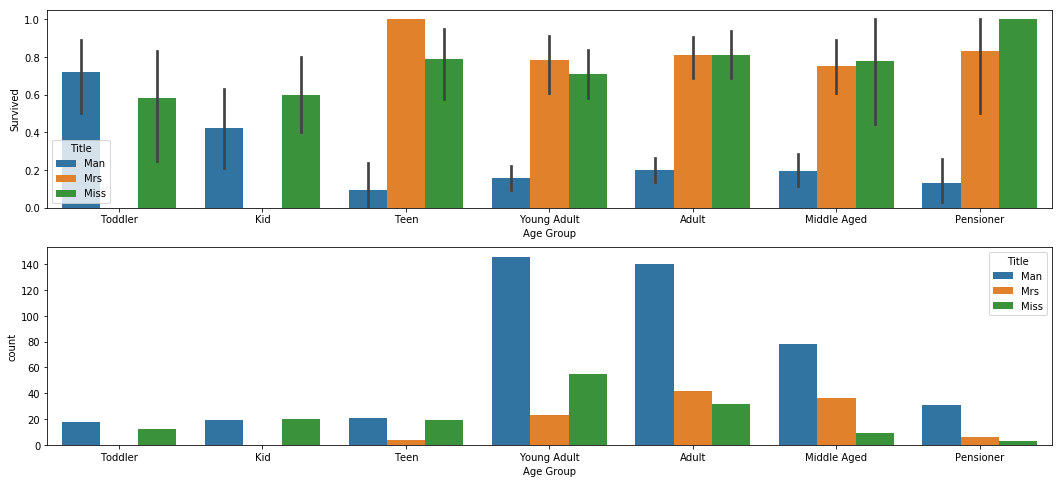

In [25]:
f, ax = plt.subplots(2, 1, figsize=(18,8))
sns.barplot('Age Group', 'Survived', hue='Title', data=training_data, ax=ax[0], order = order)
sns.countplot('Age Group', hue = 'Title', data = training_data, ax=ax[1], order = order)

Here we see that `Title` carries some meaning outisde of `Sex` and `Age` for women. Unmarried pensioners are more likely to die than those who are married.

#### Missing Age Data
We are missing about 20% of all `Age` data, I think that is way to much data to just throw away those rows. I also think `Age` carries to much significance to throw away the variable. I could fill this in using the `Age` distribution of the global user group or based on distributions for *Neighbouring* passengers, i.e. passengers with other similarities. I feel like there are pitfalls with both approaches. But lets go with the neighbourhood method.

I will fill in missing `Age` based on the mean of other passengers with the same `Pclass` and `Title`. I don't want all passengers to get equal ages though, so I will randomize a number between the mean and +- 1 Standard Deviantion. This trick was suggested by https://www.kaggle.com/startupsci/titanic-data-science-solutions even thoug he did not end up using it himself in oder to avoid randomness. I don't see this as a problem though, using a set seed will yied the same results each run, and just going by the mean is in it self a *random* descision made by me.

In [26]:
age_distributions = training_data.groupby(['Pclass', 'Title'])['Age'].describe()#.agg({'PassengerId' : 'count', 'Age' : 'mean'}).rename(columns={'PassengerId'})

In [27]:
import random
import math

In [28]:
def fill_missing_age(row):
    if row['Age'] and not math.isnan(row['Age']):
        return row['Age']
    else:
        dist = age_distributions.loc[(row['Pclass'], row['Title'])]
        return round(dist['mean'] + random.uniform(-dist['std'], dist['std']))

In [29]:
random.seed(1)
training_data['Filled Age'] = training_data['Age'].fillna(training_data.apply(fill_missing_age, axis=1))

Lets double check distributions again.

In [30]:
training_data['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [31]:
training_data['Filled Age'].describe()

count    891.000000
mean      29.185376
std       13.780584
min        0.420000
25%       20.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Filled Age, dtype: float64

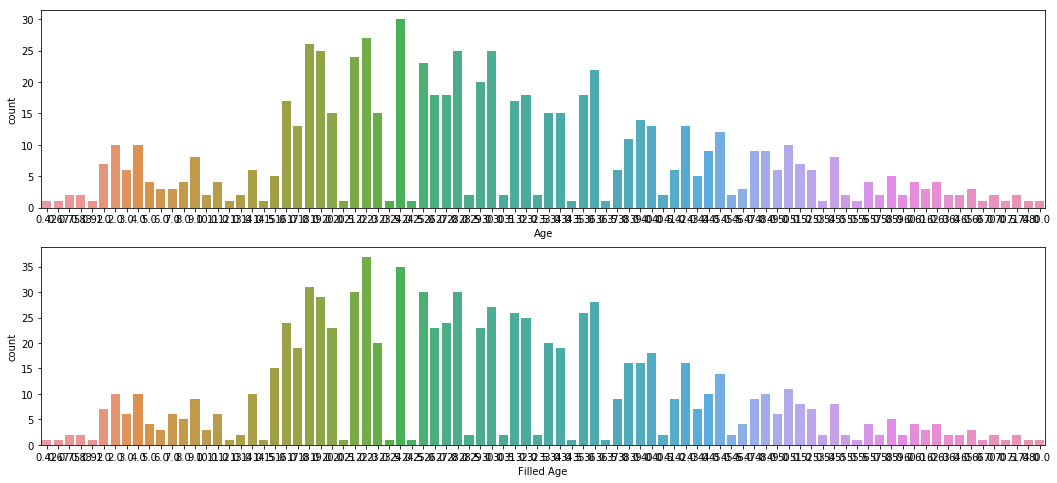

In [32]:
fig, ax = plt.subplots(2, 1,figsize=(18,8))
sns.countplot(x='Age', data=training_data, ax= ax[0])
sns.countplot(x='Filled Age', data=training_data, ax= ax[1])

Very similar means and standard deviations, great!

In [33]:
training_data['Filled Age Group'] = training_data['Filled Age'].apply(lambda x:
                                                           'Toddler' if x <= 3 else
                                                           'Kid' if x <= 12 else
                                                           'Teen' if x <= 17 else
                                                           'Young Adult' if x <= 27 else
                                                           'Adult' if x <= 39 else
                                                           'Middle Aged' if x <= 55 else
                                                           'Pensioner')

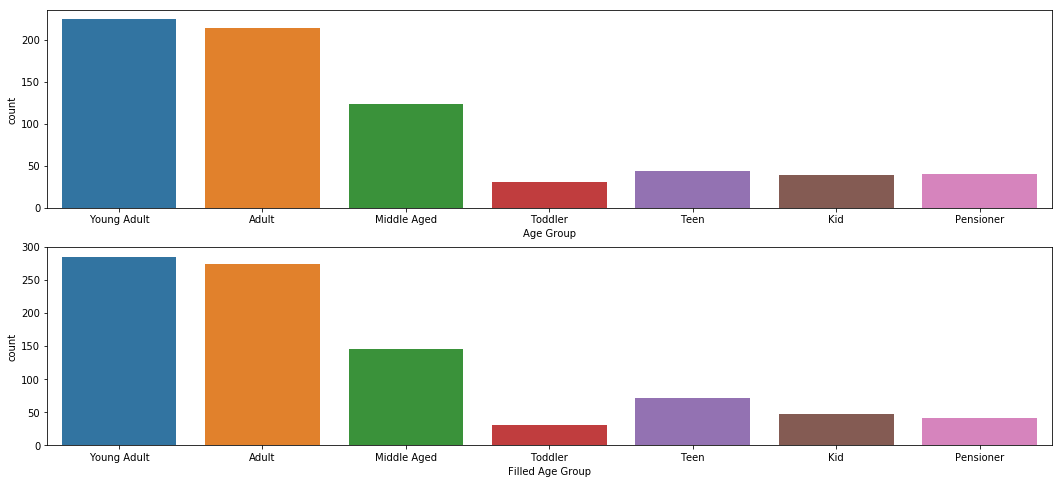

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(18,8))  
sns.countplot(x='Age Group', data = training_data, ax=ax[0])
sns.countplot(x='Filled Age Group', data = training_data, ax=ax[1])


Filled Age Groups looks very similar to previous data. Lets go ahead and use this fill method.

### Pclass

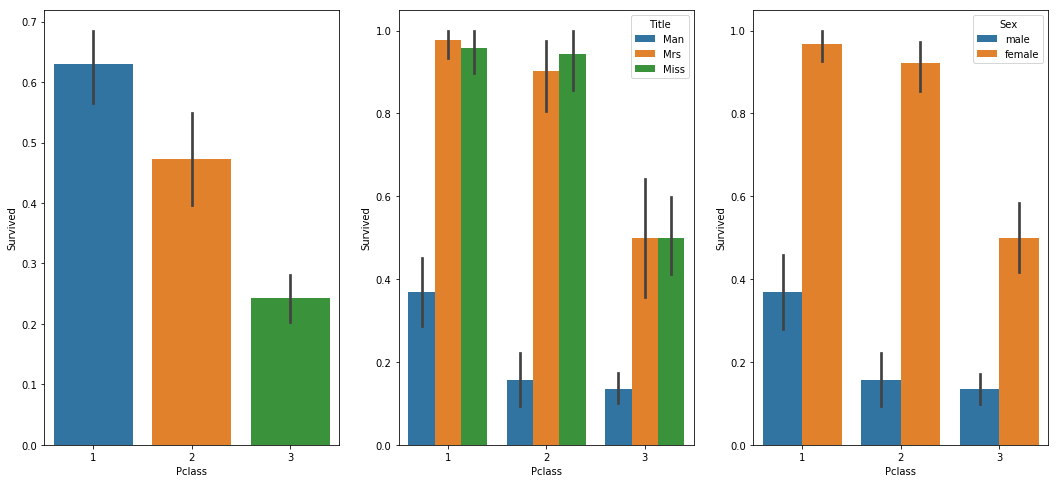

In [35]:
f, ax = plt.subplots(1, 3, figsize=(18,8))
sns.barplot('Pclass', 'Survived', data = training_data, ax=ax[0])
sns.barplot('Pclass', 'Survived', hue='Title', data = training_data, ax=ax[1])
sns.barplot('Pclass', 'Survived', hue='Sex', data = training_data, ax=ax[2])

So higher class clearly has a higher survival rate. Also the combination `Pclass` and `Title` does not seem to carry much information outside of what `Sex` the `Title` infers, so let's stick to using `Sex` in comparrisons.

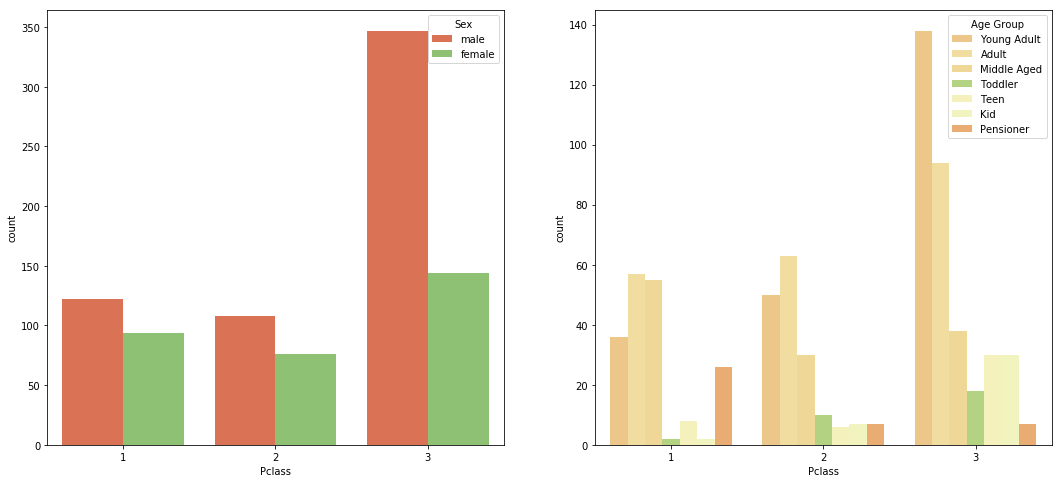

In [36]:
# Lets color by survival rates so we remember what groups are more survival prone 
sex_hues = training_data.groupby('Sex').agg('mean')['Survived']
hue_map_sex = dict(list(zip(sex_hues.index, map(plt.cm.RdYlGn, sex_hues.values))))

age_hues = training_data.groupby('Age Group').agg('mean')['Survived']
hue_map_age = dict(list(zip(age_hues.index, map(plt.cm.RdYlGn, age_hues.values))))

f, ax = plt.subplots(1, 2, figsize=(18,8))
sns.countplot('Pclass', hue='Sex', data = training_data, ax=ax[0], palette = hue_map_sex)
sns.countplot('Pclass', hue='Age Group', data = training_data, ax=ax[1], palette = hue_map_age)
#for p, text in map(ax[1].patches, ax[1].get_legend().):
#    p.set_color(plt.cm.RdYlGn(hues[p.get_]))

Clearly the higher survival rate of first class and second class passengers is not becouse of a higher ratio of the more survival prone women of the ship. It also doesn't look like it's because of a more benefitial age distribution.

Most likely `Pclass` carries a lot of information on it's own. This was probably expected.

### Embarked
* C = Cherbourg
* Q = Queenstown
* S = Southampton

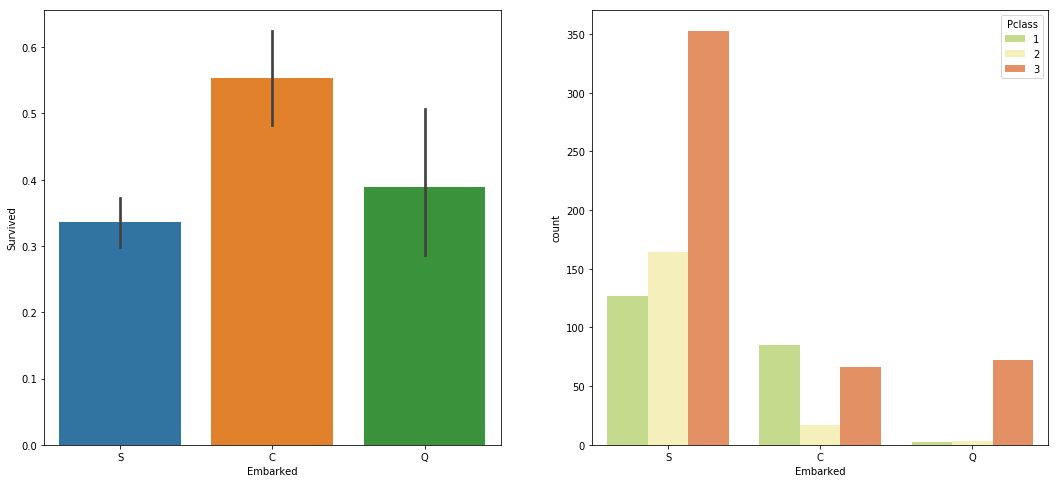

In [37]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
sns.barplot('Embarked', 'Survived', data = training_data, ax=ax[0])

pclass_hues = training_data.groupby('Pclass').agg('mean')['Survived']
hue_map_pclass = dict(list(zip(pclass_hues.index, map(plt.cm.RdYlGn, pclass_hues.values))))
sns.countplot('Embarked', hue='Pclass', data = training_data, ax=ax[1], palette = hue_map_pclass)

Survival rate is highest in Chersbourg, so is the concentration of upper class passengers. Lets check the expected survival rate for the ports of embarkment based on `Pclass`, maybe this can show if the skewed distribution of `Pclass` is the only reason survival rate varies for the ports.

In [38]:
embarked_survival = training_data.groupby(['Embarked', 'Pclass']).agg({'Survived':'sum', 'PassengerId' : 'count'}).reset_index()
pclass_survival = training_data.groupby(['Pclass']).agg({'Survived' : 'mean'}).reset_index().rename(columns={'Survived' : 'Pclass_survival_rate'})
embarked_survival = pd.merge(embarked_survival, pclass_survival, on = ['Pclass'])
estimated_embarked_survival = embarked_survival.copy()

In [39]:
estimated_embarked_survival['Survived'] = estimated_embarked_survival['PassengerId'] * estimated_embarked_survival['Pclass_survival_rate']
estimated_embarked_survival['Type'] = 'Estimate'
embarked_survival['Type'] = 'Actual'

In [40]:
embarked_survival = pd.concat([embarked_survival, estimated_embarked_survival])

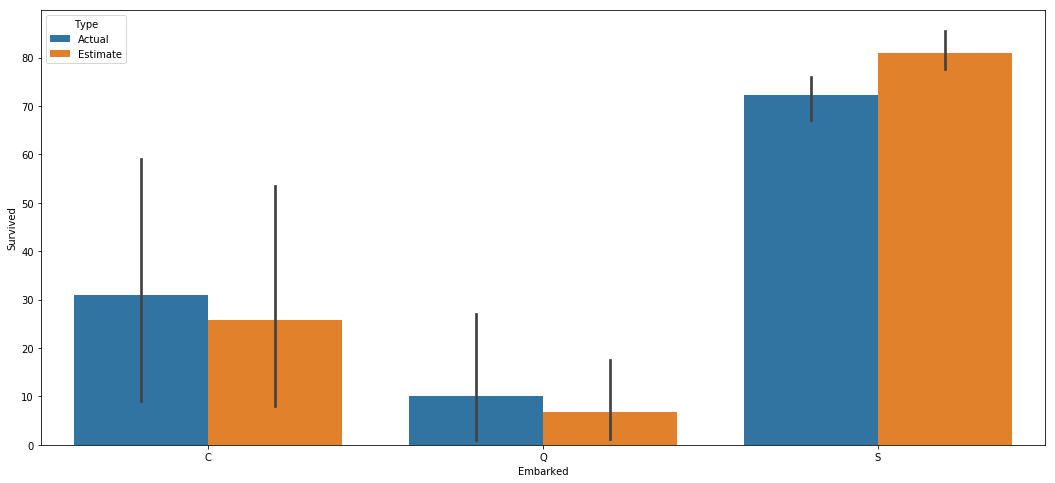

In [41]:
f, ax = plt.subplots(figsize=(18, 8))
sns.barplot('Embarked', 'Survived', hue='Type', data=embarked_survival, ax=ax)

Survival rate of the porst of embarkment is not completely described by `Pclass` distribution, but atleast we se a clear connection. I have my doubts about the usefullness of `Embarked`. I think this could be investigated more thorougly using logistic regression. But right now I choose to leave that out of scope.

I will fill in the two null values as Southhampton as this is the by far most common port of embarkment.

### Fare

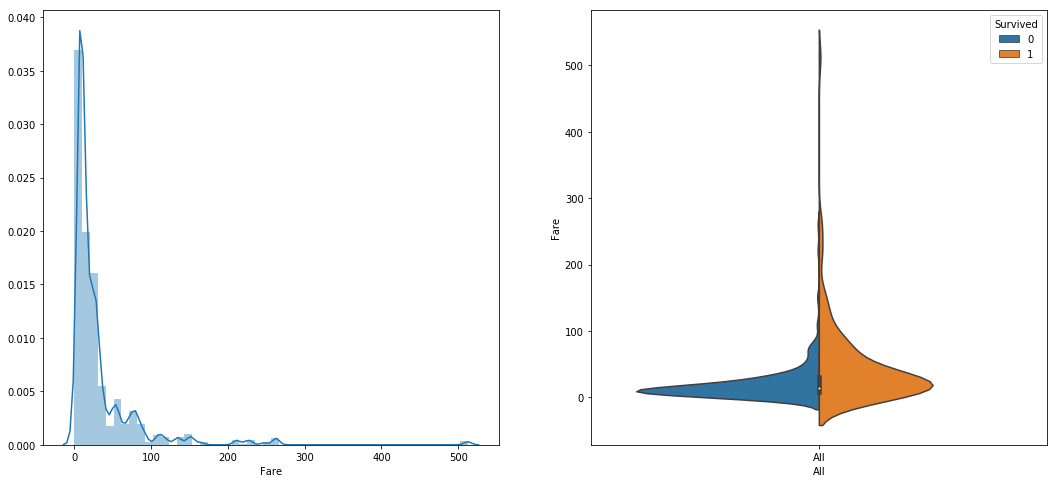

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))
tmp_data = training_data.copy()
tmp_data['All'] = "All"
sns.distplot(training_data['Fare'], ax = ax[0])
sns.violinplot(x = 'All', y='Fare', hue = 'Survived', data = tmp_data, ax = ax[1], split=True, scale='count')

Looks like survival rate goes up with higher `Fare`. Lets try to do some binning. This time around I will create 5 bins by precentiles.

In [43]:
fare_groups = list(training_data['Fare'].quantile([.2, .4, .6, .8, 1]))
fare_groups

[7.8541999999999996, 10.5, 21.679200000000002, 39.6875, 512.32920000000001]

In [44]:
training_data['Price Group'] = training_data['Fare'].apply(
                        lambda x: 
                            1 if x < fare_groups[0] else
                            2 if x < fare_groups[1] else
                            3 if x < fare_groups[2] else
                            4 if x < fare_groups[3] else
                            5)

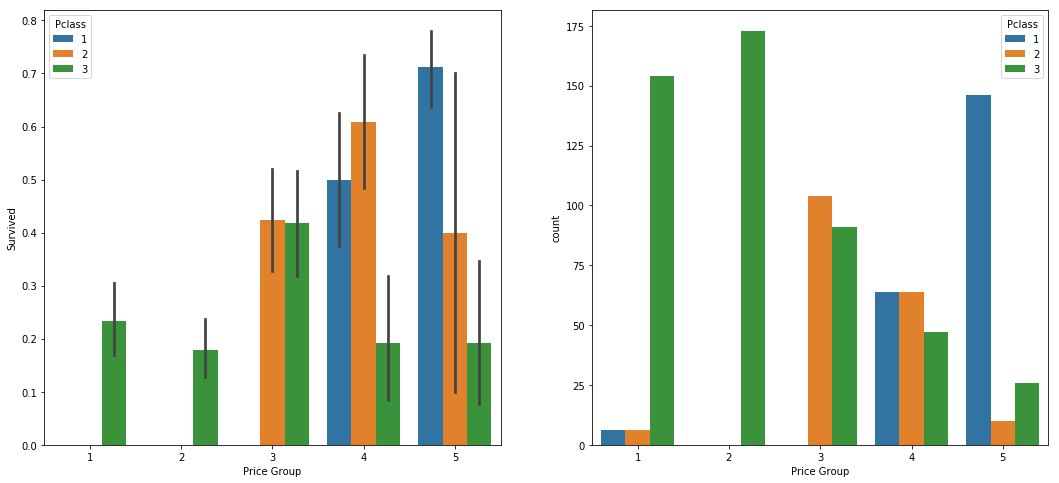

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))
sns.barplot('Price Group', 'Survived', hue='Pclass', data= training_data, ax = ax[0])
sns.countplot('Price Group', hue='Pclass', data = training_data, ax = ax[1])

Actually lets also check if we can normalize the `Fare` data. This should be done when preparing multivarite analysis, which is not something I am getting in to, but let's try it out anyway!

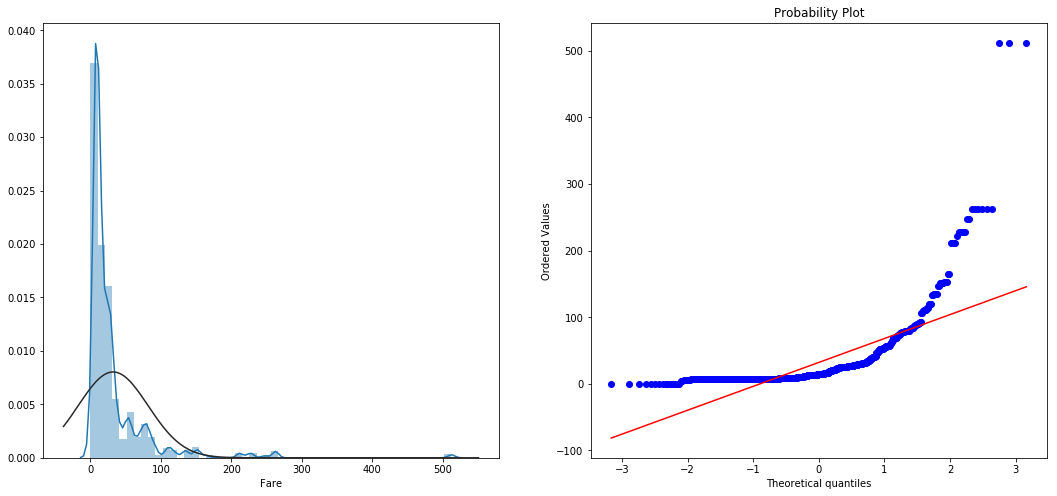

In [46]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
sns.distplot(training_data['Fare'], fit=stats.norm, ax= ax[0])
res = stats.probplot(training_data['Fare'], plot = ax[1])

Positive skewedness! Lets try the trick I learnt by https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python: transform `Fare` with the log function! (Log(n+1) to handle zero values.)

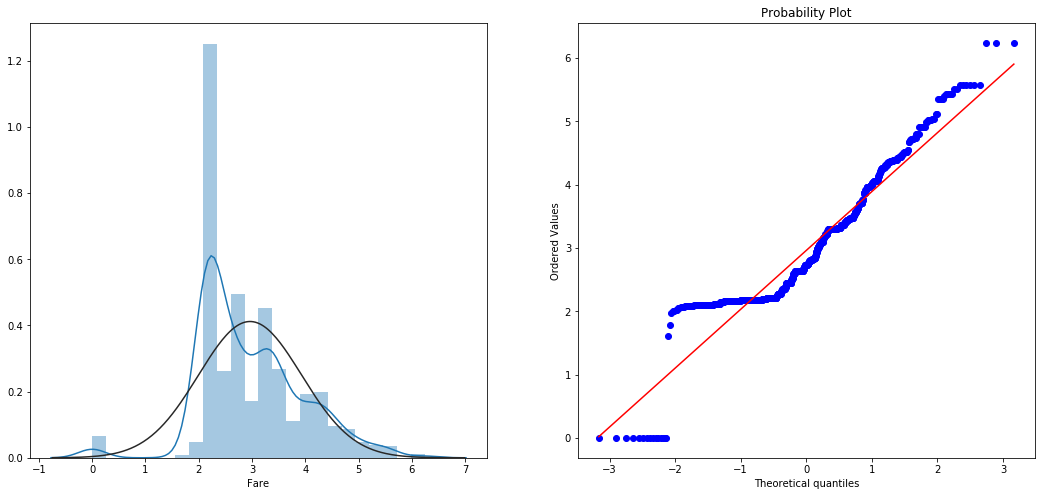

In [47]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
sns.distplot(np.log1p(training_data['Fare']), fit=stats.norm, ax= ax[0])
res = stats.probplot(np.log1p(training_data['Fare']), plot = ax[1])

I don't think I succeded. I will leave these atempts for now and maybe get back to it further along my data analysis career!

### Cabin
`Cabin` unfortunately has lots of empty entries, and for that reason I feel it is useless to try to infer any information from it.

### Ticket, Parch and SibSp
`Ticket` I interpret as a number shared by passengers who bought their Titanic ticket together. It might give us a clue about which passengers are travelling together. 
`Parch` and `SibSp` should give us a sense of family sizes onboard the Titanic. They do not infer any information about which passengers are related, but should give the most accurate estimates for group sizes.

In [48]:
print("{} passengers share their ticket number with atleast one more person.".format(training_data.duplicated(subset=['Ticket']).sum()))

210 passengers share their ticket number with atleast one more person.


In [49]:
training_data['Family Size'] = training_data['Parch'] + training_data['SibSp'] + 1

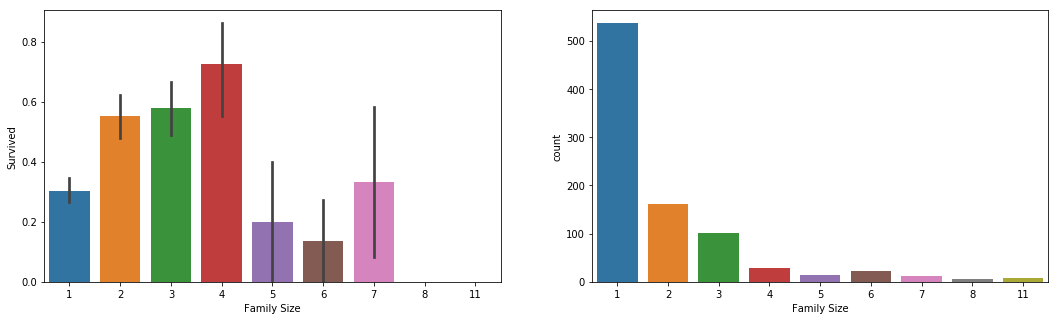

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(18,5))
sns.barplot('Family Size', 'Survived', data= training_data, ax = ax[0])
sns.countplot('Family Size', data = training_data, ax = ax[1])

Traveling with your family seems benefitial!

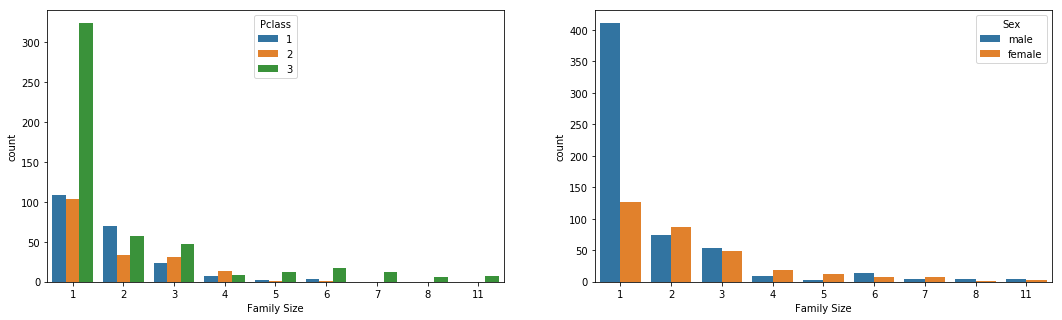

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(18,5))
sns.countplot('Family Size', hue='Pclass', data = training_data, ax = ax[0])
sns.countplot('Family Size', hue='Sex', data = training_data, ax = ax[1])

Its more common for men and third class passengers to travel alone.

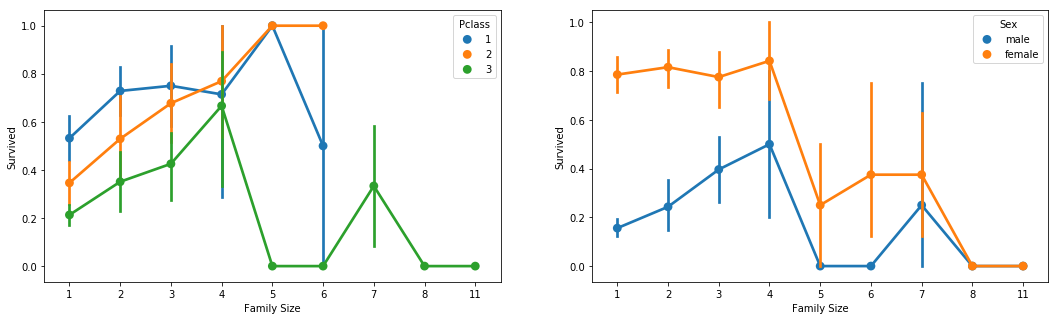

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(18,5))
sns.factorplot('Family Size', 'Survived', hue='Pclass', data = training_data, ax = ax[0])
sns.factorplot('Family Size', 'Survived',  hue='Sex', data = training_data, ax = ax[1])
plt.close(2)
plt.close(3)

Looks like its positive to have a larger family size up until a certain point where survivalrate starts dropping again. Maybe we could do some binning on all family sizes larger than 3 or 4. Actually yes, lets do that, all family sizes larger than 4 will be said to be 5. I choose 5 because survival rate seems to drop of substantially at that point and I dont want to bin those families together with the most survival prone family size of 4.

Notice I just bundled Parch and SibSp together. This might be a mistake, but I am leaving it like that for now.

In [53]:
training_data['Binned Family Size'] = training_data['Family Size'].apply(lambda x: x if x < 5 else 5)

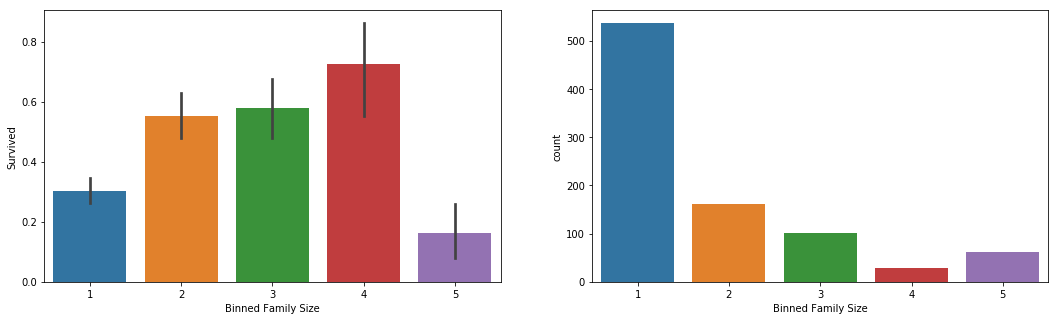

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(18,5))
sns.barplot('Binned Family Size', 'Survived', data= training_data, ax = ax[0])
sns.countplot('Binned Family Size', data = training_data, ax = ax[1])

Last time I tackled this problem I introduced the `Surviving Companions` and `Dead Companions` variables, which I defined as the number of surviving respectively dead passengers with the same ticketnumber as the passenger, of course excluding the passengers own fate. 

I am not sure how I feel about a variable like this. One major flaw is that I can never get the full picture of this variable, as the survival numbers of passengers in the test set are hidden from me. This means it will only be correct for any company only present in the training data, and that gives me no help in classifying the test set. Also, I feel like when setting up an experiment like this with survival as target variable, I should produce an analysis that helps determine survival rate of passengers in a (purely hypothetical) identical situation. Otherwise what value have I produced. So this time I am leaving it out.

## Conclusions
I have come up with a couple of insight that I hope will allow me to better predict survival on the Titanic. They come in two forms:
* What variables to analyse
* How to handle null values

### What variables to analyse
The variables I have chosen for analysis, coupled with the significance I think they hold, are as follows:
* Most important
    * `Pclass`
    * `Title`
    * `Age` (Binned as `Age Group`)
* Less important
    * `Fare` (Binned as `Price Group`)
    * `Family Size`
* Questionable
    * Embarked

### How to handle null values
* Title - All men will be calles Men, and women will be classified as either Mrs or Miss based on current tile and age.
* Age - Fill based on neighbours in `Pclass` and `Title`
* Embarked - Fill two missing values as S

# Classification
This time using Scikit-Learn. I have started reading `Hands-On Machine Learning with Scikit-Learn & TensorFlow` which is much more hands on than machinelearning literature I have studied previously. I will test out some of the techniques suggested in the first chapter.

First lets create a test set. I have already deviated from the approach recomended in the book where EDA is not performed on the test set. I will bring that knowledge with me into my next project.

First things first, lets transform the data. This time around I will stick to my old transformation functions working directly on the dataframe, instead of sklearn transformations. 

In [329]:
# Transformation functions
def set_title(row):
    if row['Sex'] == 'male':
        return "Man"
    elif row['Title'] in ['Miss', 'Mrs']:
        return row['Title']
    elif row['Age'] >= 31:
        return "Mrs"
    else:
        return "Miss"
    
def fill_missing_age(row):
    if row['Age'] and not math.isnan(row['Age']):
        return row['Age']
    else:
        dist = age_distributions.loc[(row['Pclass'], row['Title'])]
        return round(dist['mean'] + random.uniform(-dist['std'], dist['std']))
    
def title_feature(df):
    df['Title'] = df['Name'].str.extract(r'.*\,\s(.*?)\.', expand=False)
    df['Title'] = df.apply(set_title, axis=1)
    return df

def age_feature(df):
    # I always want the same "random" results
    random.seed(1)
    df['Age'] = df['Age'].fillna(df.apply(fill_missing_age, axis=1))
    
    df['Age Group'] = df['Age'].apply(
                            lambda x:
                               1 if x <= 3 else
                               2 if x <= 12 else
                               3 if x <= 17 else
                               4 if x <= 27 else
                               5 if x <= 39 else
                               6 if x <= 55 else
                               7)
    return df

def price_group_feature(df):
    fare_groups = [7.8541999999999996, 10.5, 21.679200000000002, 39.6875, 512.32920000000001]
    df['Price Group'] = df['Fare'].apply(
                            lambda x: 
                                1 if x < fare_groups[0] else
                                2 if x < fare_groups[1] else
                                3 if x < fare_groups[2] else
                                4 if x < fare_groups[3] else
                                5)
    return df

def family_size_feature(df):
    df['Family Size'] = df['Parch'] + df['SibSp'] + 1
    return df
    

# df should not include the target variable Survived
def transform_data(df):
    
    # Title
    df = title_feature(df)
    
    # Age
    df = age_feature(df)
    
    # Embarked
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # Fare
    df = price_group_feature(df)
    
    # Family Size
    df = family_size_feature(df)
    
    # Drop unnecessary variables
    df = df[['Age Group', 'Pclass', 'Title', 'Price Group', 'Family Size', 'Embarked']]
    
    return df.copy()

In [270]:
training_data = pd.read_csv('titanic_train.csv')

In [271]:
X_df, Y_df = transform_data(training_data), training_data['Survived']

In [272]:
X_df.head()

,Age Group,Pclass,Title,Price Group,Family Size,Embarked
0,4,3,Man,1,2,S
1,5,1,Mrs,5,2,C
2,4,3,Miss,2,1,S
3,5,1,Mrs,5,2,S
4,5,3,Man,2,1,S


To create my test set I will use 20% of the training data, with a similar `Title` and `Pclass` distribution. The StratifiedShuffleSplit class of sklearn only supports one variable stratification (?), so I will create a temporary label combining `Title` and `Pclass`. 

In [273]:
from sklearn.model_selection import StratifiedShuffleSplit

X_df['PclassTitle'] = X_df['Pclass'].apply(str)+X_df['Title']


split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=1)
for training_index, test_index in split.split(X_df, X_df['PclassTitle']):
    training_X = X_df.loc[training_index]
    training_Y = Y_df.loc[training_index]
    test_X = X_df.loc[test_index]
    test_Y = Y_df.loc[test_index]
    
    


In [274]:
pd.DataFrame({'All Data' :X_df['PclassTitle'].value_counts() / len(X_df), 'Training Data' :training_X['PclassTitle'].value_counts() / len(training_X), 'Test Data' :test_X['PclassTitle'].value_counts() / len(test_X)})

,All Data,Test Data,Training Data
1Man,0.136925,0.139665,0.136236
1Miss,0.054994,0.055866,0.054775
1Mrs,0.050505,0.050279,0.050562
2Man,0.121212,0.122905,0.120787
2Miss,0.039282,0.039106,0.039326
2Mrs,0.046016,0.044693,0.046348
3Man,0.389450,0.391061,0.389045
3Miss,0.114478,0.111732,0.115169
3Mrs,0.047138,0.044693,0.047753


Distributions of the class combinations are very similar in all parts of the data set!

In [275]:
pd.DataFrame({'All Data' :Y_df.value_counts() / len(Y_df), 'Training Data' :training_Y.value_counts() / len(training_Y), 'Test Data' :test_Y.value_counts() / len(test_Y)})

,All Data,Test Data,Training Data
0,0.616162,0.659218,0.605337
1,0.383838,0.340782,0.394663


We also have a somewhat similar distribution of our target variable. Maybe I should have done stratification on `Survived` instead? 

Anyway, lets drop the combined column and create some dummy variables.

In [276]:
training_X = training_X.drop('PclassTitle', axis= 1)
test_X = test_X.drop('PclassTitle', axis= 1)

In [277]:
training_X = pd.get_dummies(training_X, columns=['Title', 'Embarked'])
test_X = pd.get_dummies(test_X, columns=['Title', 'Embarked'])

Lets try using the sklearn LogisticRegression classifier!

In [278]:
from sklearn.linear_model import LogisticRegression

In [279]:
training_X = training_X.values
test_X = test_X.values

In [280]:
training_Y = training_Y.values
test_Y = test_Y.values

In [281]:
# First lets try the most basic one!
logit = LogisticRegression(random_state=1)
logit.fit(training_X, training_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [282]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [283]:
Y_hat = logit.predict(test_X)
accuracy_score(test_Y, Y_hat)

0.82681564245810057

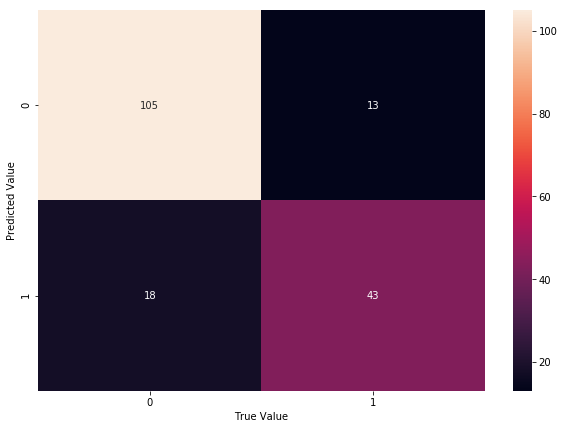

In [284]:
confusing_matrix_df = pd.DataFrame(confusion_matrix(test_Y, Y_hat))

f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(confusing_matrix_df, annot=True, fmt=".0f", ax = ax)
ax.set_ylabel('True Value')
ax.set_xlabel('Predicted Value')

Cool! This is very close to the accuracy I had when training last time using my Maximumx Entropy classifier, and my previous feature set. I have better accuracy on classifying dead passengers, which I think is expected as they are more common. 

Lets try some other features and see what performs best.

I should use some more generic pipeline here, but this time I will just redo the transformations I like

In [285]:
# Without Embarked this time
def transform_data2(df):  
    # Title
    df = title_feature(df)
    
    # Age
    df = age_feature(df)
    
    # Fare
    df = price_group_feature(df)
    
    # Family Size
    df = family_size_feature(df)
    
    # Drop unnecessary variables
    df = df[['Age Group', 'Pclass', 'Title', 'Price Group', 'Family Size']]
    
    return df.copy()

In [286]:
training_data = pd.read_csv('titanic_train.csv')

In [287]:
X_df, Y_df = transform_data2(training_data), training_data['Survived']

In [288]:
X_df['PclassTitle'] = X_df['Pclass'].apply(str)+X_df['Title']


split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=1)
for training_index, test_index in split.split(X_df, X_df['PclassTitle']):
    training_X = X_df.loc[training_index]
    training_Y = Y_df.loc[training_index]
    test_X = X_df.loc[test_index]
    test_Y = Y_df.loc[test_index]

In [289]:
training_X = training_X.drop('PclassTitle', axis= 1)
test_X = test_X.drop('PclassTitle', axis= 1)

In [290]:
training_X = pd.get_dummies(training_X, columns=['Title'])
test_X = pd.get_dummies(test_X, columns=['Title'])

In [291]:
training_X = training_X.values
test_X = test_X.values

In [292]:
training_Y = training_Y.values
test_Y = test_Y.values

In [293]:
# First lets try the most basic one!
logit = LogisticRegression(random_state=1)
logit.fit(training_X, training_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [294]:
Y_hat = logit.predict(test_X)
accuracy_score(test_Y, Y_hat)

0.7988826815642458

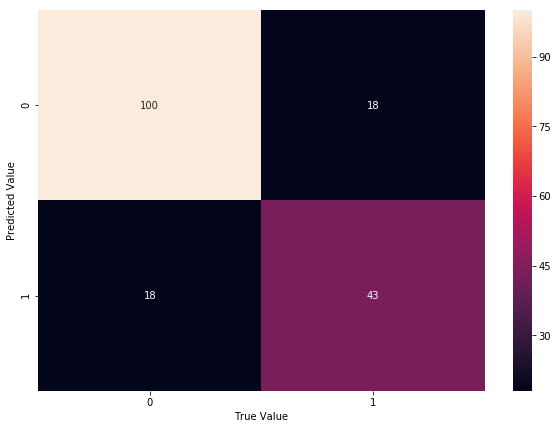

In [295]:
confusing_matrix_df = pd.DataFrame(confusion_matrix(test_Y, Y_hat))
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(confusing_matrix_df, annot=True, fmt=".0f", ax = ax)
ax.set_ylabel('True Value')
ax.set_xlabel('Predicted Value')

Worse! Lets try normalizing `Age` and `Fare` instead of creating bins. And lets nring back `Embarked`

In [301]:
def age_feature_normalized(df):
    # I always want the same "random" results
    random.seed(1)
    df['Age'] = df['Age'].fillna(df.apply(fill_missing_age, axis=1))
    
    df['Age'] = df['Age'].apply(lambda x:( x - df['Age'].min() / df['Age'].max()-df['Age'].min()))
    
    return df

def fare_feature_normalized(df):
    df['Fare'] = df['Fare'].apply(lambda x:( x - df['Fare'].min() / df['Fare'].max()-df['Fare'].min()))
    
    return df

def transform_data3(df):  
    # Title
    df = title_feature(df)
    
    # Age
    df = age_feature_normalized(df)
    
    # Fare
    df = fare_feature_normalized(df)
    
    # Embarked
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # Family Size
    df = family_size_feature(df)
    
    # Drop unnecessary variables
    df = df[['Age', 'Pclass', 'Title', 'Fare', 'Family Size', 'Embarked']]
    
    return df.copy()

In [312]:
training_data = pd.read_csv('titanic_train.csv')

In [313]:
X_df, Y_df = transform_data3(training_data), training_data['Survived']

In [314]:
X_df['PclassTitle'] = X_df['Pclass'].apply(str)+X_df['Title']


split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=1)
for training_index, test_index in split.split(X_df, X_df['PclassTitle']):
    training_X = X_df.loc[training_index]
    training_Y = Y_df.loc[training_index]
    test_X = X_df.loc[test_index]
    test_Y = Y_df.loc[test_index]

In [315]:
training_X = training_X.drop('PclassTitle', axis= 1)
test_X = test_X.drop('PclassTitle', axis= 1)

In [316]:
training_X = pd.get_dummies(training_X, columns=['Title', 'Embarked'])
test_X = pd.get_dummies(test_X, columns=['Title', 'Embarked'])

In [317]:
training_X = training_X.values
test_X = test_X.values

In [318]:
training_Y = training_Y.values
test_Y = test_Y.values

In [319]:
# First lets try the most basic one!
logit = LogisticRegression(random_state=1)
logit.fit(training_X, training_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [320]:
Y_hat = logit.predict(test_X)
accuracy_score(test_Y, Y_hat)

0.79329608938547491

In [352]:
confusing_matrix_df = pd.DataFrame(confusion_matrix(test_Y, Y_hat))
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(confusing_matrix_df, annot=True, fmt=".0f", ax = ax)
ax.set_ylabel('True Value')
ax.set_xlabel('Predicted Value')

ValueError: Found input variables with inconsistent numbers of samples: [179, 418]

## The real test set
I would love to keep on testing features, especially using some kind of cross folding. (Must be possible for features and not just hyper parameters)

In the futore I would also love to try some other classification methods, and would be especially interested in one that lets me draw "understandable" conclusions about the data. Such as a method that would let me find important feature combinations.

For now, lets see how our new features perform on the real test set. As I have done no finetuning using my own test set, I feel like I might as well train using all of the training data. In the future I will try to only perform EDA on a portion of the training data, and only train using that portion.

In [326]:
training_data = pd.read_csv('titanic_train.csv')
test_data = pd.read_csv('titanic_test.csv')

In [331]:
training_X, training_Y = transform_data(training_data), training_data['Survived']
test_X = transform_data(test_data)


In [332]:
training_X = pd.get_dummies(training_X, columns=['Title', 'Embarked'])
test_X = pd.get_dummies(test_X, columns=['Title', 'Embarked'])

In [333]:
training_X = training_X.values
test_X = test_X.values

In [335]:
training_Y = training_Y.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [336]:
# First lets try the most basic one!
logit = LogisticRegression(random_state=1)
logit.fit(training_X, training_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [337]:
Y_hat = logit.predict(test_X)
#accuracy_score(test_Y, Y_hat)

In [340]:
pd.DataFrame(index = test_data['PassengerId'], data=Y_hat, columns=['Survived']).to_csv('titanic_submission3.csv')

Got 0.75119, again a large set back from my first submission. Maybe my feature `Surviving Companions` was really powerful?

Lets also try another classification method just for the heck of it. I will use the RandomForest classifier as it has shown up in many Kernels. I don't know how it works yet, but think it benefits from cross validation. I will get around tho this classifier again in the future, but for now (22:56 after a long work day) I would just like to see some results!

In [353]:
training_data = pd.read_csv('titanic_train.csv')
test_data = pd.read_csv('titanic_test.csv')

In [354]:
training_X, training_Y = transform_data(training_data), training_data['Survived']
test_X = transform_data(test_data)


In [355]:
training_X = pd.get_dummies(training_X, columns=['Title', 'Embarked'])
test_X = pd.get_dummies(test_X, columns=['Title', 'Embarked'])

In [356]:
training_X = training_X.values
test_X = test_X.values

In [357]:
training_Y = training_Y.values

In [359]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)
model.fit(training_X, training_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [363]:
Y_hat = model.predict(test_X)

In [364]:
pd.DataFrame(index = test_data['PassengerId'], data=Y_hat, columns=['Survived']).to_csv('titanic_submission4.csv')

Maybe I can improve this by actually tuning the model. Well, thats an exercise for another day. Time to go to bed.